In [2]:
from typing import Union, Dict, Any, TypedDict, cast, List, Literal
from pathlib import Path

import pandas as pd
from ulid import ULID
import firebase_admin
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
from google.cloud.firestore_v1.types import WriteResult
from google.api_core.datetime_helpers import DatetimeWithNanoseconds
from google.cloud.firestore import CollectionReference, DocumentReference

In [3]:
EventType = Literal["new-session", "interaction"]

class EventData(TypedDict):
    correctTag: str 
    draggedTag: str
    eventType: EventType
    orderingId: int
    sessionId: str
    targetWord: str

class Word(TypedDict):
    word: str
    tag: str

class SessionData(TypedDict):
    eventType: EventType
    serie: str
    sessionId: str
    startTime: DatetimeWithNanoseconds
    words: List[Word]

In [3]:
def is_ulid(string: str) -> bool:
    try:
        ULID.from_str(string)
        return True
    except ValueError:
        return False

In [4]:
cred_path = Path("../firebase_key.json").resolve()

- [CollectionReference](https://cloud.google.com/python/docs/reference/firestore/latest/google.cloud.firestore_v1.collection.CollectionReference)
- [DocumentReference](https://cloud.google.com/python/docs/reference/firestore/latest/google.cloud.firestore_v1.document.DocumentReference)

In [5]:
class Firebase:
    def __init__(self, cert_path: Union[Path, str]) -> None:
        if isinstance(cert_path, str):
            cert_path = Path(cert_path).resolve()

        if isinstance(cert_path, Path):
            assert cert_path.exists(), f"Certificate file {cert_path} does not exist."
            cert_path = cert_path.resolve()
            cert = credentials.Certificate(str(cert_path))
        else:
            raise TypeError(f"cert_path must be a Path or str. Got {type(cert_path)}")

        self.cert = cert
        
        try:
            self.app = firebase_admin.initialize_app(cert)
        except Exception as e:
            print("Firebase app already initialized.", e)
            self.app = firebase_admin.get_app()

        self.db = firestore.client(self.app)


    def __del__(self) -> None:
        self.db.close()
        firebase_admin.delete_app(self.app)


    def get_collection(self, collection_path: str) -> CollectionReference:
        coll_ref = self.db.collection(collection_path)
        return coll_ref


    def get_document(self, document_path: str) -> DocumentReference:
        doc_ref = self.db.document(document_path)
        return doc_ref
    
    
    def get_document_snap_dict(self, document_path:str) -> Dict[str, Any]:
        doc_ref = self.get_document(document_path)
        doc_snap = doc_ref.get()
      
        if not doc_snap.exists:
            raise ValueError(f"Document {document_path} does not exist.")
        
        doc_snap_dict = doc_snap.to_dict()

        assert isinstance(doc_snap_dict, dict)
        return doc_snap_dict
    

    def update_document(self, document_path: str, data: Dict[str, Any]) -> float:
        document_referece:DocumentReference = self.get_document(document_path)
        wres:WriteResult = document_referece.update(data)

        time_res:float = wres.update_time.timestamp() # type: ignore

        assert isinstance(time_res, float)

        return time_res

In [6]:
fb = Firebase(cred_path)

In [7]:
events_coll = fb.get_collection("events")

In [40]:
new_session_data = []
interaction_data = []

for i in events_coll.list_documents():
    if is_ulid(i.path.split("/")[-1]):
        d:dict = i.get().to_dict()
        if d.get("eventType") == "new-session":
            session_data:SessionData = cast(SessionData, d)
            new_session_data.append(session_data)
            # session_id = session_data["sessionId"]
            # words = session_data["words"]
            # print(f"Session ID: {session_id}, Words: {len(words)}")
        else: # if d.get("eventType") == "interaction":
            event_data:EventData = cast(EventData, d)
            interaction_data.append(event_data)
            # session_id = event_data["sessionId"]
            # print(f"Event ID: {i.id}, Session ID: {session_id}, Event Type: {event_data['eventType']}")
    else:
        continue

In [41]:
new_session_df = pd.DataFrame(new_session_data)
interaction_df = pd.DataFrame(interaction_data)

In [42]:
interaction_df.shape

(24815, 6)

In [43]:
new_session_df.to_csv("data/new_session_data_250603.csv", index=False)
interaction_df.to_csv("data/interaction_data_250603.csv", index=False)

# Analyzing Dataset

In [14]:
new_session_df = pd.read_csv("data/new_session_data_250603.csv")
interaction_df = pd.read_csv("data/interaction_data_250603.csv")

In [15]:
def cast_words(words: str):
    assert isinstance(words, str), f"Expected str, got {type(words)}"
    words_ = cast(List[Word], eval(words))
    return words_

new_session_df['words'] = new_session_df['words'].apply(cast_words)

To exclude some 'trash' rows from the dataset (rows in which members of the group were using the website to test), I'm using only the rows from a specific range.

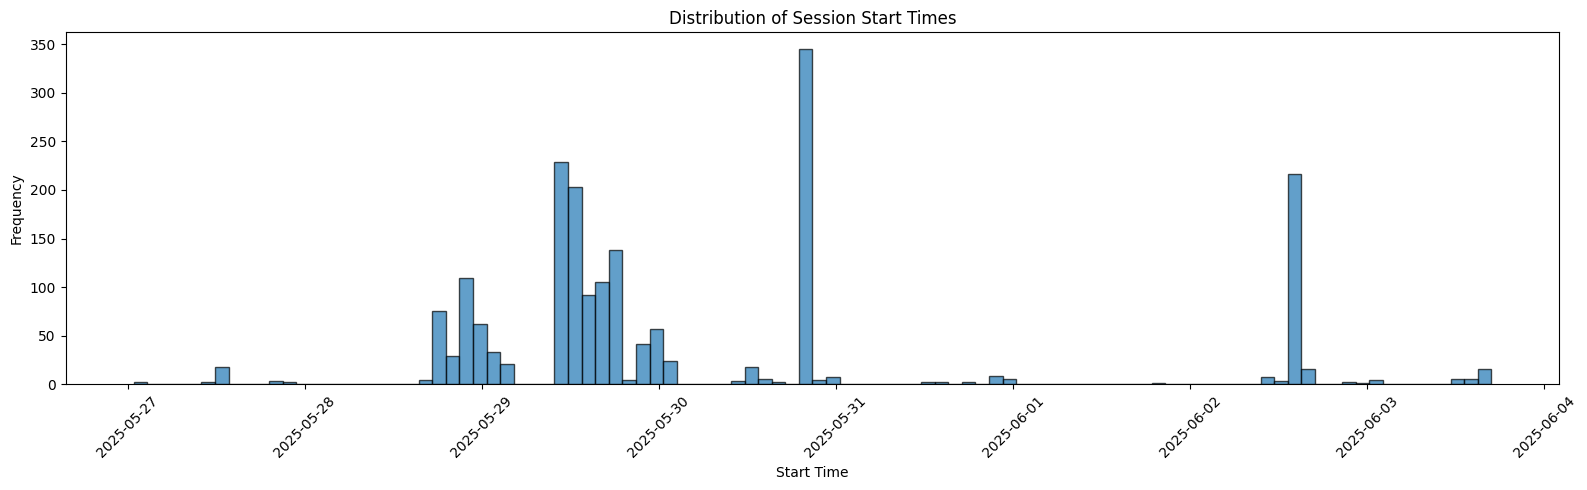

(1905, 5)

In [16]:
#  time data "2025-05-29 11:52:04+00:00" doesn't match format "%Y-%m-%d %H:%M:%S.%f%z",
new_session_df['startTime'] = pd.to_datetime(new_session_df['startTime'], format="mixed")

# Create histogram of timestamps
plt.figure(figsize=(16, 5))
plt.hist(new_session_df['startTime'], bins=100, alpha=0.7, edgecolor='black')
plt.title('Distribution of Session Start Times')
plt.xlabel('Start Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

start_date = '2025-05-28'
end_date = '2025-06-30'

new_session_df = new_session_df[
    (new_session_df['startTime'] >= start_date) & 
    (new_session_df['startTime'] <= end_date)
]

new_session_df.shape

# Get students that tags ~~almost~~ every word

In [20]:
word_counts_df = pd.DataFrame({
    'sessionId': new_session_df['sessionId'],
    'word_count': new_session_df['words'].apply(len)
}).reset_index(drop=True)
word_counts_df.head(3)

,sessionId,word_count
0,ZyZQ2uxUx7,7
1,Y9BROEENaq,7
2,1F61mzeAfO,7


In [35]:
print(interaction_df.shape)
interaction_df.groupby('sessionId').apply(
    lambda group: group.drop_duplicates(subset=['correctTag', 'targetWord', 'sessionId', 'draggedTag'])).reset_index(drop=True)

(24815, 6)


/tmp/ipykernel_690936/402802647.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interaction_df.groupby('sessionId').apply(


,correctTag,targetWord,eventType,orderingId,sessionId,draggedTag
0,Pontuação,",",interaction,0,-3Q1xJXqzA,Pontuação
1,Pontuação,.,interaction,1,-3Q1xJXqzA,Pontuação
2,Verbo,aprovado,interaction,2,-3Q1xJXqzA,Verbo Auxiliar
3,Verbo,aprovado,interaction,3,-3Q1xJXqzA,Artigo
4,Verbo,aprovado,interaction,4,-3Q1xJXqzA,Substantivo
...,...,...,...,...,...,...
22025,Verbo,gostou,interaction,6,zzy7YJuk_E,Substantivo
22026,Verbo,gostou,interaction,7,zzy7YJuk_E,Preposição+Artigo
22027,Verbo,gostou,interaction,8,zzy7YJuk_E,Verbo
22028,Preposição+Artigo,do,interaction,9,zzy7YJuk_E,Preposição+Artigo


In [27]:
interaction_tw_df = interaction_df.groupby('sessionId')['targetWord'].nunique().reset_index()
interaction_tw_df.head(3)

,sessionId,targetWord
0,-3Q1xJXqzA,13
1,-6gZ-mHdzv,7
2,-CS8WhEL5b,12


In [40]:
result_df = word_counts_df.merge(interaction_tw_df, on='sessionId', how='inner')
initial_shape = result_df.shape
target_df = result_df[abs(result_df['word_count'] - result_df['targetWord']) == 4]
print(f"Initial shape: {initial_shape}, Target shape: {target_df.shape}")

Initial shape: (1412, 3), Target shape: (30, 3)


In [41]:
target_df

,sessionId,word_count,targetWord
10,45G1ZLuysH,5,1
106,icYcsUknBT,13,9
165,oujUZdfMpy,7,3
169,nd8sGIAACL,7,3
335,P0AicXt9Se,6,2
366,8x-kiFpqAm,9,5
374,4zU1hox2-7,12,8
419,6mzJx8yMuV,16,12
467,o9uLCYc0BY,6,2
524,rZvC0RiJEH,5,1


In [12]:
target_df['sessionId'].sample()

1017    p4yrjuDppj
Name: sessionId, dtype: object

# Final DF

In [13]:
merged_df = interaction_df.merge(new_session_df, on='sessionId', how='inner')
merged_df = merged_df[['correctTag', 'targetWord', 'orderingId', 'sessionId', 'draggedTag', 'serie']]
merged_df

,correctTag,targetWord,orderingId,sessionId,draggedTag,serie
0,Pontuação,.,0,Jh1538yCDy,Pontuação,6-ensino-fundamental
1,Artigo,O,1,Jh1538yCDy,Substantivo,6-ensino-fundamental
2,Substantivo,banco,2,Jh1538yCDy,Artigo,6-ensino-fundamental
3,Substantivo,banco,3,Jh1538yCDy,Substantivo,6-ensino-fundamental
4,Artigo,O,4,Jh1538yCDy,Artigo,6-ensino-fundamental
...,...,...,...,...,...,...
24678,Pontuação,",",0,Halvf7QSu2,Pontuação,9-ensino-fundamental
24679,Pontuação,!,1,Halvf7QSu2,Pontuação,9-ensino-fundamental
24680,Verbo de Ligação,fosse,2,Halvf7QSu2,Verbo,9-ensino-fundamental
24681,Verbo,chegar,3,Halvf7QSu2,Verbo de Ligação,9-ensino-fundamental


In [18]:
# new_session_df[new_session_df['sessionId'] == 'Dh9h9CQvkS']['words'].values[0]

In [17]:
# merged_df[merged_df['sessionId'] == 'Dh9h9CQvkS']

In [14]:
final_df = merged_df.merge(target_df['sessionId'], on='sessionId', how='inner')
final_df.shape

(21946, 6)

In [ ]:
# final_df.to_csv("data/final_df_250603.csv", index=False)

In [ ]:
final_df[final_df['sessionId'] == '_89k7RcRRS']

,correctTag,targetWord,orderingId,sessionId,draggedTag,serie
5194,Pontuação,.,0,_89k7RcRRS,Verbo,7-ensino-fundamental
5220,Pontuação,.,1,_89k7RcRRS,Conjunção Subordinativa,7-ensino-fundamental
5229,Pontuação,.,2,_89k7RcRRS,Preposição,7-ensino-fundamental
5254,Pontuação,.,3,_89k7RcRRS,Pontuação,7-ensino-fundamental
5306,Advérbio,cedo,4,_89k7RcRRS,Pronome,7-ensino-fundamental
5310,Advérbio,cedo,5,_89k7RcRRS,Verbo,7-ensino-fundamental
5313,Advérbio,cedo,6,_89k7RcRRS,Substantivo,7-ensino-fundamental
5315,Advérbio,cedo,7,_89k7RcRRS,Advérbio,7-ensino-fundamental
5326,Advérbio,amanhã,8,_89k7RcRRS,Verbo Auxiliar,7-ensino-fundamental
5329,Advérbio,amanhã,9,_89k7RcRRS,Verbo,7-ensino-fundamental
